# Volatility Surface Fitting



Loaded /Users/amankesarwani/PycharmProjects/cso-lab/data/synthetic/vol_surface_hh.csv -> 12 rows, columns: ['expiry', 'strike', 'iv']
Missing values per column:
expiry    0
strike    0
iv        0
dtype: int64
rows: 12


,expiry,strike,iv,tenor,vol
0,0.25,-0.5,0.596685,0.25,0.596685
1,0.25,0.0,0.624614,0.25,0.624614
2,0.25,0.5,0.626147,0.25,0.626147
3,0.25,1.0,0.733366,0.25,0.733366
4,0.50,-0.5,0.604478,0.50,0.604478


vol(1, 60) = 0.6894341533461418
vol([1,3,6], [50,60,70]) = [0.68943415 0.68943415 0.68943415]


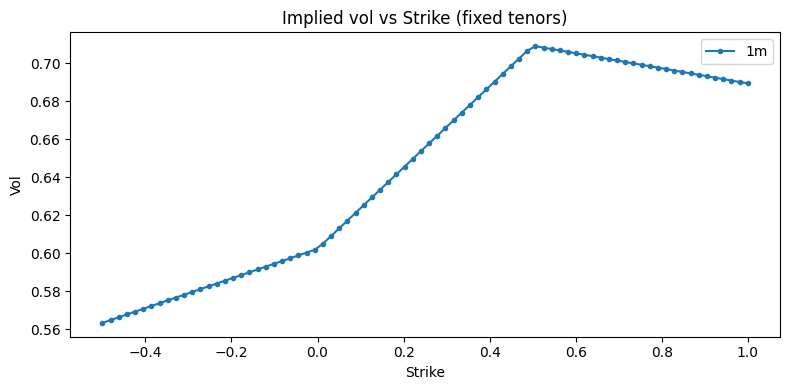

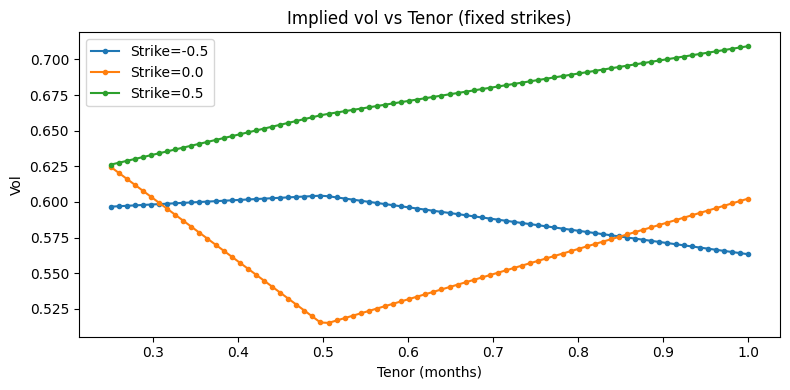

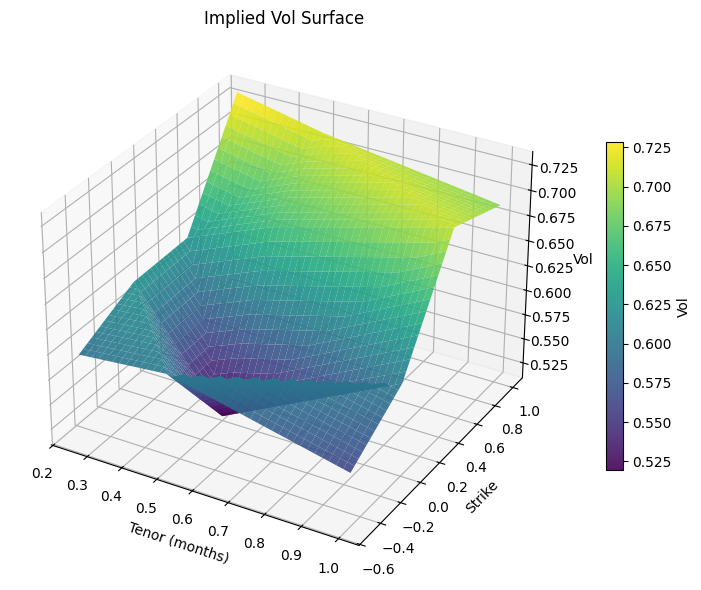

In [4]:
# python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from cso_lab.vol_surface import VolSurface
from cso_lab.data import load_vol_surface

# load (uses cso_lab.data.load_vol_surface)
df = load_vol_surface('vol_surface_hh', verbose=True)

# normalize column names to lower-case
df.columns = [c.lower() for c in df.columns]

# map expiry/tenor column -> tenor (in months)
if 'expiry' in df.columns:
    # if expiry is datetime-like convert to months from today, else treat as numeric tenor
    if pd.api.types.is_datetime64_any_dtype(df['expiry']) or pd.api.types.is_object_dtype(df['expiry']):
        try:
            dt = pd.to_datetime(df['expiry'], errors='coerce')
        except Exception:
            dt = pd.to_datetime(df['expiry'], errors='coerce')
        if dt.notna().any():
            ref = pd.Timestamp.today()
            df['tenor'] = ((dt - ref).dt.days / 30.4375).clip(lower=0)
        else:
            df['tenor'] = pd.to_numeric(df['expiry'], errors='coerce')
    else:
        df['tenor'] = pd.to_numeric(df['expiry'], errors='coerce')
elif 'tenor' in df.columns:
    df['tenor'] = pd.to_numeric(df['tenor'], errors='coerce')
else:
    raise ValueError("No expiry/tenor column found in vol surface data.")

# map vol/iv column -> vol
if 'iv' in df.columns:
    df['vol'] = pd.to_numeric(df['iv'], errors='coerce')
elif 'vol' in df.columns:
    df['vol'] = pd.to_numeric(df['vol'], errors='coerce')
else:
    # try common alternatives
    for alt in ('implied_vol', 'impliedvol', 'sigma'):
        if alt in df.columns:
            df['vol'] = pd.to_numeric(df[alt], errors='coerce')
            break
    if 'vol' not in df.columns:
        raise ValueError("No implied-vol column found (expected iv/vol/implied_vol/etc).")

# ensure strike numeric
if 'strike' in df.columns:
    df['strike'] = pd.to_numeric(df['strike'], errors='coerce')
else:
    raise ValueError("No strike column found in vol surface data.")

# drop invalid rows
df = df.dropna(subset=['tenor', 'strike', 'vol']).reset_index(drop=True)
print("rows:", len(df))
display(df.head())

# build VolSurface
vs = VolSurface.from_df(df, tenor_col='tenor', strike_col='strike', vol_col='vol')

# example queries
print("vol(1, 60) =", vs.vol(1, 60))
print("vol([1,3,6], [50,60,70]) =", vs.vol([1,3,6], [50,60,70]))

# plotting parameters
min_strike, max_strike = df['strike'].min(), df['strike'].max()
min_tenor, max_tenor = df['tenor'].min(), df['tenor'].max()

# 1) Vol vs Strike for several tenors (prefer common tenors if present)
present_tenors = np.unique(np.round(df['tenor']).astype(int))
preferred = [t for t in (1, 3, 6, 12) if t in present_tenors]
if preferred:
    tenor_list = preferred
else:
    tenor_list = np.unique(df['tenor'])[:4]

strikes = np.linspace(min_strike, max_strike, 80)
plt.figure(figsize=(8,4))
for t in tenor_list:
    vols = vs.vol(float(t), strikes)
    label = f'{int(t)}m' if float(t).is_integer() else f'{t:.2f}'
    plt.plot(strikes, vols, marker='.', label=label)
plt.title('Implied vol vs Strike (fixed tenors)')
plt.xlabel('Strike')
plt.ylabel('Vol')
plt.legend()
plt.tight_layout()
plt.show()

# 2) Vol vs Tenor for a few strikes
strike_list = list(np.unique(df['strike']))[:3]
tenors = np.linspace(min_tenor, max_tenor, 80)
plt.figure(figsize=(8,4))
for k in strike_list:
    vols = vs.vol(tenors, float(k))
    plt.plot(tenors, vols, marker='.', label=f'Strike={k}')
plt.title('Implied vol vs Tenor (fixed strikes)')
plt.xlabel('Tenor (months)')
plt.ylabel('Vol')
plt.legend()
plt.tight_layout()
plt.show()

# 3) 3D surface plot (tenor, strike, vol)
Tg, Kg = np.meshgrid(
    np.linspace(min_tenor, max_tenor, 40),
    np.linspace(min_strike, max_strike, 40),
)
pts_t = Tg.ravel()
pts_k = Kg.ravel()
Vg = vs.vol(pts_t, pts_k).reshape(Tg.shape)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(Tg, Kg, Vg, cmap='viridis', edgecolor='none', alpha=0.9)
ax.set_xlabel('Tenor (months)')
ax.set_ylabel('Strike')
ax.set_zlabel('Vol')
ax.set_title('Implied Vol Surface')
fig.colorbar(surf, shrink=0.6, label='Vol')
plt.tight_layout()
plt.show()
